In [2]:
from os.path import isfile, join
import numpy as np
import cv2
from os import listdir
import matplotlib.pyplot as plt
import tensorflow as tf
 
mypath='./carracing_screenshots/'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = np.zeros((984,64,64,3))
for n in range(0, len(onlyfiles)):
  images[n] = cv2.imread( join(mypath,onlyfiles[n]) )

In [3]:
print(images[0])

[[[101. 203. 101.]
  [101. 203. 101.]
  [101. 203. 101.]
  ...
  [101. 203. 101.]
  [101. 203. 101.]
  [101. 203. 101.]]

 [[101. 203. 101.]
  [101. 203. 101.]
  [101. 203. 101.]
  ...
  [101. 203. 101.]
  [101. 203. 101.]
  [101. 203. 101.]]

 [[101. 203. 101.]
  [101. 203. 101.]
  [101. 203. 101.]
  ...
  [101. 203. 101.]
  [101. 203. 101.]
  [101. 203. 101.]]

 ...

 [[101. 203. 101.]
  [101. 203. 101.]
  [101. 203. 101.]
  ...
  [101. 220. 101.]
  [101. 228. 101.]
  [101. 228. 101.]]

 [[101. 203. 101.]
  [101. 203. 101.]
  [101. 203. 101.]
  ...
  [101. 220. 101.]
  [101. 228. 101.]
  [101. 228. 101.]]

 [[101. 203. 101.]
  [101. 203. 101.]
  [101. 203. 101.]
  ...
  [101. 220. 101.]
  [101. 228. 101.]
  [101. 228. 101.]]]


In [4]:
train_images = images[:600].astype('float32')
test_images = images[600:].astype('float32')


# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.


TRAIN_BUF = len(train_images)
BATCH_SIZE = 100

TEST_BUF = len(test_images)

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)




In [25]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=4, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=4, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=128, kernel_size=4, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=256, kernel_size=4, strides=(2, 2), activation='relu'),
          # No activation
          tf.keras.layers.Dense(latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Reshape(target_shape=(1, 1, 1024)),
          tf.keras.layers.Conv2DTranspose(
              filters=128,
              kernel_size=5,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=5,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=6,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=3,
              kernel_size=6,
              strides=(2, 2),
              padding="SAME",
              activation='sigmoid'),
        ]
    )

  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits




In [26]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables):
  optimizer.apply_gradients(zip(gradients, variables))

epochs = 100
latent_dim = 1024
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)


def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      print(predictions[0])  
      plt.imshow(predictions)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()




Tensor("strided_slice_6:0", shape=(8, 8, 3), dtype=float32)


TypeError: Image data of dtype object cannot be converted to float

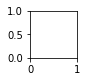

In [27]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    gradients, loss = compute_gradients(model, train_x)
    apply_gradients(optimizer, gradients, model.trainable_variables)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)
